# Sktime

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/sktime.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/sktime.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/sktime.ipynb)

This notebook is a brief tour of [Sktime](https://www.sktime.net) along with my notes on time series analysis.

In [ ]:
%pip install -q sktime

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from datetime import datetime
from scipy.signal import periodogram
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


def parse_time(t):
    year = int(t)
    rem = t - year
    month = int(rem * 12) + 1
    return datetime(year, month, 1)

## Time Series

Time series data is a sequence of observations or data points collected over time. The sequence is key because each observation is a continuation of the story told by the previous observations. Over time, patterns can emerge that can be analyzed and ultimately used to make predictions about the future.

Take the step count on your Apple Watch. It's a series of timestamps and values (the date and the number of steps you took). Over time, your watch is able to "learn" your habits and can even predict how many steps you're likely to take during the day. That prediction is an example of time series forecasting.

### Lags and Autocorrelation

A _lag_ is the difference in time between two observations. If you're looking at stock price data, a lag of 1 day would be the stock price today compared to the stock price yesterday. By examining lags, you can identify trends, seasonality, and other temporal patterns in the data.

_Autocorrelation_ is a measure of how similar a time series is to a lagged version of itself. The technical [definition](https://en.wikipedia.org/wiki/Autocorrelation) is: _the similarity between observations as a function of the time lag between them._ A positive autocorrelation indicates that observations close in time tend to be similar while negative autocorrelation suggests the opposite. For example, big movements in stock price tend to be followed by movements in the same direction. In trading, this is known as _momentum_.

### Stationarity

_Stationarity_ is a statistical property of a time series where the mean and variance are constant over time. In a stationary series, there are no discernable patterns like trends or seasonality; the series looks roughly the same at any given point in time. For example, plotting daily stock returns (the percent change in price) over many years should have a mean hovering around zero. In contrast, plotting the closing price over the same period would show a clear upward trend and exhibit seasonal patterns within each year.

Think of stationarity as like an anchor that keeps the series from drifting. If it is stationary, then it will revert to the mean even after large shocks. If it is not stationary, then each shock permanently changes the series.

Stationarity is important because many forecasting models assume it. It's often necessary to transform a non-stationary series before modeling. Some models also allow you to define known events that could shock the series, such as holidays or promotions, to account for these in the forecast. These are known as _exogenous variables_.

### Seasonality

Seasonality is a pattern that repeats at regular intervals. Here in New England, we have four distinct seasons that repeat every year.

In stock market data, seasonality for an individual stock might be the tendency for a retail stock to increase during the holiday season. For the market as a whole, there are documented seasonal patterns such as the [January effect](https://en.wikipedia.org/wiki/January_effect) or [Sell in May](https://en.wikipedia.org/wiki/Sell_in_May) (and go away).

In the airline passenger dataset that we'll look at shortly, you'll see a clear seasonal pattern every summer when people travel more. This is an example of _multiplicative seasonality_, where the amplitude of the seasonality increases with the level of the series. In contrast, _additive seasonality_ is when the the seasonal effect is constant.

### Modeling

A _model_ refers to a [mathematical model]( https://en.wikipedia.org/wiki/Mathematical_model), a mathematical representation of a system. Models can be deterministic or stochastic. Deterministic models, such as the [Black-Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) for options pricing, provide precise outputs given specific inputs.

On the other hand, stochastic models, like [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) for modeling stock prices, incorporate randomness and have variability in their predictions. These models are also known as _statistical models_ or _stochastic processes_.

### White Noise

In the context of time series data, _white noise_ is a sequence of data points where each point is independent and identically distributed (IID). The concept is crucial because it represents pure randomness. White noise is often used as a baseline model to compare against more complex models that attempt to capture patterns in the data.

When modeling time series data, if the difference between the observed values and the predicted values (the residuals) are not white noise, then the model is not capturing all of the information in the data and underfitting. If the residuals do resemble white noise, then the model is capturing all of the information and is a good fit; what remains is essentially randomness and not predictable by any model.

### Random Walks

A _random walk_ is a stochastic process that describes a path consisting of a succession of random steps. The [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis) is a financial theory that states stock prices evolve according to a random walk and thus cannot be predicted. In [_A Random Walk Down Wall Street_](https://www.amazon.com/Random-Walk-Down-Wall-Street-ebook/dp/B0B3G6FVT5/), [Burton Malkiel](https://en.wikipedia.org/wiki/Burton_Malkiel) presents an experiment he conducted at Princeton where a hypothetical stock was created by flipping a coin. The stock price went up if the coin landed heads and down if it landed tails. The resulting price chart looked like a real stock chart and was meant to illustrate his point that stock prices are unpredictable and follow a random walk.

The random walk hypothesis complements the [efficient-market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis) (EMH) by suggesting that the unpredictable nature of stock prices is due to the efficiency of the market. The EMH posits that stock prices reflect all available information, at any given time, and are therefore unpredictable.

## Sunspots

This is a dataset of the monthly mean relative sunspot numbers from 1749 to 1983. We'll resample to yearly and forward-fill any missing years.

In [2]:
sunspots = sm.datasets.get_rdataset("sunspots").data
sunspots["time"] = sunspots["time"].apply(parse_time)

sunspots["time"] = pd.to_datetime(sunspots["time"])
sunspots.set_index("time", inplace=True)

# resample to yearly and average
sunspots = sunspots.resample("Y").mean()  # YE in Pandas 2+

# can't have 0 or negative sunspots
sunspots = sunspots[sunspots["value"] > 0]
full_range = pd.date_range(sunspots.index.min(), sunspots.index.max(), freq="Y")
missing_years = full_range.difference(sunspots.index)
print(f"Missing years: {missing_years.year.to_list()}")

Missing years: [1810]


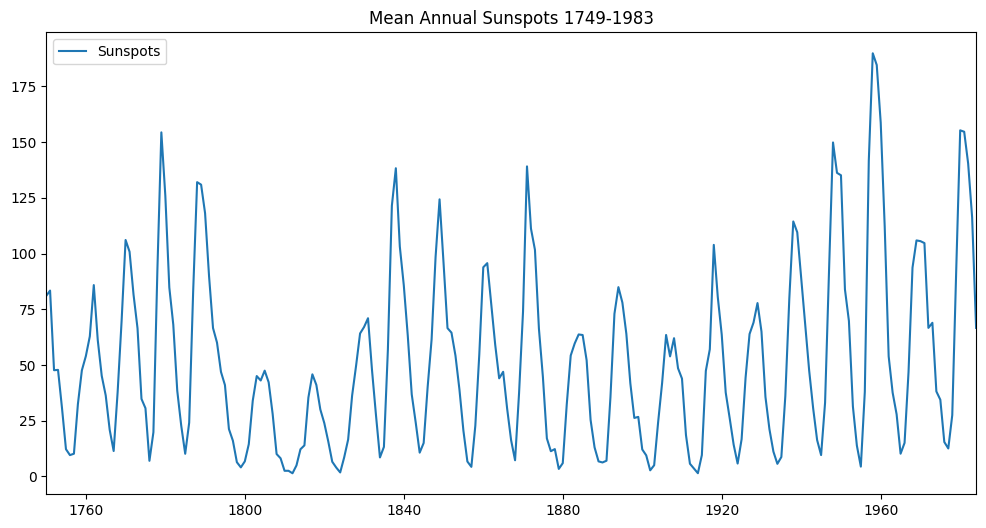

In [3]:
# this will introduce a NaN for missing years that we can forward-fill
sunspots = sunspots.reindex(full_range)
sunspots["value"] = sunspots["value"].fillna(method="ffill")

# plot
plt.figure(figsize=(12, 6))

plt.plot(sunspots.index, sunspots["value"], label="Sunspots")
plt.title("Mean Annual Sunspots 1749-1983")
plt.xlim(sunspots.index.min(), sunspots.index.max())
plt.legend()
plt.show()

### Seasonality Analysis

We can use a [periodogram](https://en.wikipedia.org/wiki/Periodogram) to identify the dominant cycles in the series.

The periodogram measures the [power spectral density](https://en.wikipedia.org/wiki/Spectral_density) (PSD) of the series at different frequencies. The frequency with the highest PSD is the dominant cycle in the series. The PSD is obtained by taking the squared magnitude of the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) of the series.

The [solar cycle](https://en.wikipedia.org/wiki/Solar_cycle) is an 11-year cycle in the Sun's activity. We see a spike just before 0.1 in the periodogram, which is close to 11 years (0.1 cycles/year = 1 cycle/10 years).

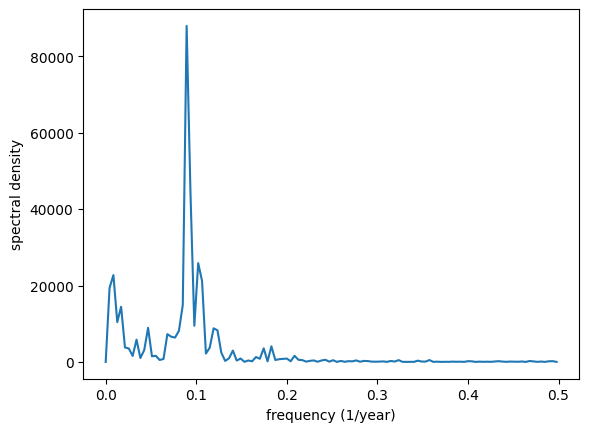

In [4]:
frequencies, spectrum = periodogram(sunspots["value"])
plt.plot(frequencies, spectrum)
plt.xlabel("frequency (1/year)")
plt.ylabel("spectral density")
plt.show()

### Autocorrelation

We'll use ACF and PACF to identify the seasonality in the series. The ACF and PACF plots show the correlation between the series and its lagged values.

The ACF plot shows the correlation between the current value of the series and its past values at different lags. The appearance of the cyclic pattern indicates the presence of seasonality in the series, which could indicate that the sunspot activity has a regular cycle.

The PACF plot shows the partial correlation between the current value of the series and its past values, controlling for the values at intermediate lags. The shaded area is the confidence interval and the spikes outside the confidence interval are considered significant.

Imagine taking a slice of the series and sliding it along the series itself, taking note of how similiar or disimilar the slice is. You can think of the ACF and PACF as a way of quantifying this similarity.

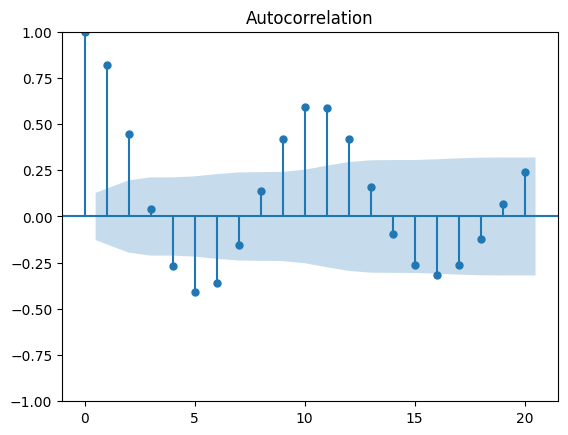

In [5]:
plot_acf(sunspots["value"].squeeze(), lags=20)
plt.show()

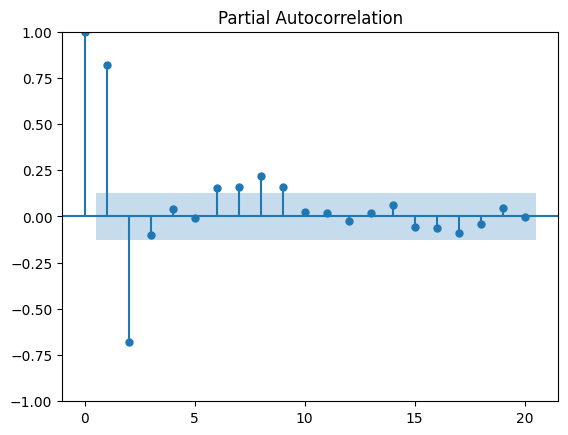

In [6]:
plot_pacf(sunspots["value"].squeeze(), lags=20)
plt.show()

### Augmented Dickey-Fuller Test

The [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) is a statistical test that can be used to determine if a series has a [unit root](https://en.wikipedia.org/wiki/Unit_root), which is a property of non-stationary time series. In modern practice, the [augmented](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) test is used, which addresses limitations of the original test. The null hypothesis of the test is that the series has a unit root and is non-stationary (drifts).

The result is a tuple containing:
- **Test statistic**: A higher negative value suggests stronger evidence of the series being stationary (rejecting the null hypothesis).
- **P-value**: The probability of observing the test statistic if the null hypothesis is true. A p-value less than 0.05 is considered statistically significant.
- **Lags**: `8`
- **Observations**: `226`
- **Critical values**: The test statistic values that correspond to different significance levels. If the test statistic is less than the critical value, then the null hypothesis can be rejected with the corresponding level of confidence.
- **Information criterion**: Lower value indicates a better model fit.

In [7]:
result = adfuller(sunspots["value"])
result

(-2.3818907216888916,
 0.14691298578092832,
 8,
 226,
 {'1%': -3.4596204846395824,
  '5%': -2.8744153028455948,
  '10%': -2.5736320761218576},
 1843.9940348043972)

## AutoARIMA

R provides the [`auto.arima`](https://www.rdocumentation.org/packages/forecast/topics/auto.arima) function in the [`forecast`](https://www.rdocumentation.org/packages/forecast) package, which is implemented in Python in [pmdarima](https://github.com/alkaline-ml/pmdarima).

### AR component

The AR component models the relationship between an observation and a number of lagged observations. It's akin to saying, "Today's weather is partly based on yesterday's weather." The model is written as $AR(p)$ where $p$ is the order of the AR component (the number of lagged observations). A simple and widely encountered version is the $AR(1)$ model, or _first-order autoregressive_ model (one lag). It is mathematically expressed as:

$$
X_t = \phi X_{t-1} + \epsilon_t
$$

where:
  * $X_t$ is the observation at time $t$ (current)
  * $\phi$ is the measurement (coefficient) of the influence of the previous observation $X_{t-1}$ on the current observation
  * $\epsilon_t$ is the residual error at time $t$

Stationarity is a requirement of AR models.

### MA component

The MA component models the relationship between an observation and the residual errors from a moving average model applied to lagged observations. This component helps smooth out the noise in the data, providing a clearer signal for forecasting. The model is written as $MA(q)$ where $q$ is the order. A $MA(1)$ model can be mathematically expressed as:

$$
X_t = \mu + \epsilon_t + \theta \epsilon_{t-1}
$$

where:
  * $\mu$ is the mean of the series
  * $\epsilon_t$ is the residual error at time $t$
  * $\theta$ is the coefficient of the previous residual error $\epsilon_{t-1}$

If $\vert\phi\vert < 1$, the series is _invertible_. Invertibility means that the model can be written as an infinite moving average (MA) process. Like stationarity for AR models, invertibility is a requirement for MA models.

In [8]:
y_train, y_test = temporal_train_test_split(y=sunspots["value"], test_size=20)

# determine the forecasting horizon from the test size
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh = fh.to_relative(y_train.index[-1])

### Summary

The dependent variable, `y` is the yearly mean sunspots. There are `215` observations from 1749 to 1963.

The model, `SARIMAX(3, 0, 1)x(0, 0, [1,2], 11)` has the following parameters:
  * the non-seasonal order has 3 auto-regressive terms, no differencing, and 1 moving average term
  * the seasonal order has no auto-regressive term, no differencing, 1 moving average term at lag 1, and 2 moving average terms at lag 2, with a period of 11
_Order_ refers to components of the model ($p$, $d$, $q$, and $s$). The auto-regressive terms capture how much the previous observations influence the current observation. The moving average terms are different from simple moving averages used to smooth data. In this context, they are used to model the _error component_ of the series. Each moving average term (in this case, 1) is a way to incorporate the error from previous obversations into the model.

When reading the coefficients, the `P>|z|` column is the p-value associated with the z-statistic (`z` column). The p-value is used to determine the significance of the coefficients, or whether or not the coefficients are significantly different from zero. A very-low p-value, typically less than `0.05` by convention, indicates that the coefficient is significant. All of the coefficients listed in the summary here are significant.

The intercept coefficient (`30.3832`) suggests a baseline level of sunspots when other factors are zero.

The seasonal (`ar.S.L11`) coefficient (`0.2725` with p-value of `0.001`) is significant, confirming the importance of the 11-year seasonal cycle.

The [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) at lag 1 (`L1`) has a `Prob(Q)` (p-value) of `0.88`, which is high and indicates that the residuals at this lag are white noise. This means the model is capturing the information in the data at this lag (if the residuals were not white noise, it would suggest that the model is not capturing everything).

The [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) tests the null hypothesis that the residuals are normally distributed. The `Prob(JB)` (p-value) of `0.00` is very low, which suggests that the residuals are not normally distributed. This can affect the reliability of some statistical tests and confidence intervals that assume normality. This means that [transformations](https://en.wikipedia.org/wiki/Power_transform) like Box-Cox could be applied to the target variable (sunspots) to stabilize the variance. The skewness and kurtosis are also reported.

The log likelihood, AIC, BIC, and HQIC will serve as benchmarks for comparison to other models.

In [9]:
arima_forecaster = AutoARIMA(sp=11, seasonal=True, suppress_warnings=True)
arima_forecaster.fit(y_train)
print(arima_forecaster.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  215
Model:             SARIMAX(3, 0, 1)x(0, 0, [1, 2], 11)   Log Likelihood                -900.434
Date:                                 Thu, 09 May 2024   AIC                           1816.868
Time:                                         14:06:19   BIC                           1843.833
Sample:                                     12-31-1749   HQIC                          1827.763
                                          - 12-31-1963                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     30.3832      5.661      5.367      0.000      19.287      41

### Forecasting

The MAPE (mean absolute percentage error) and sMAPE (symmetric mean absolute percentage error) are measurements of forecast accuracy. MAPE can be biased when dealing with small values, while sMAPE is symmetric (balanced), giving equal weight to over and under forecasts.

Interpreting the results, we see that the ensemble method performed the best, which was expected. The ARIMA model took the longest to fit and performed the worst. Both ARIMA and ETS (exponential smoothing) models performed worse than the simple Naive forecaster.

#### ARIMA

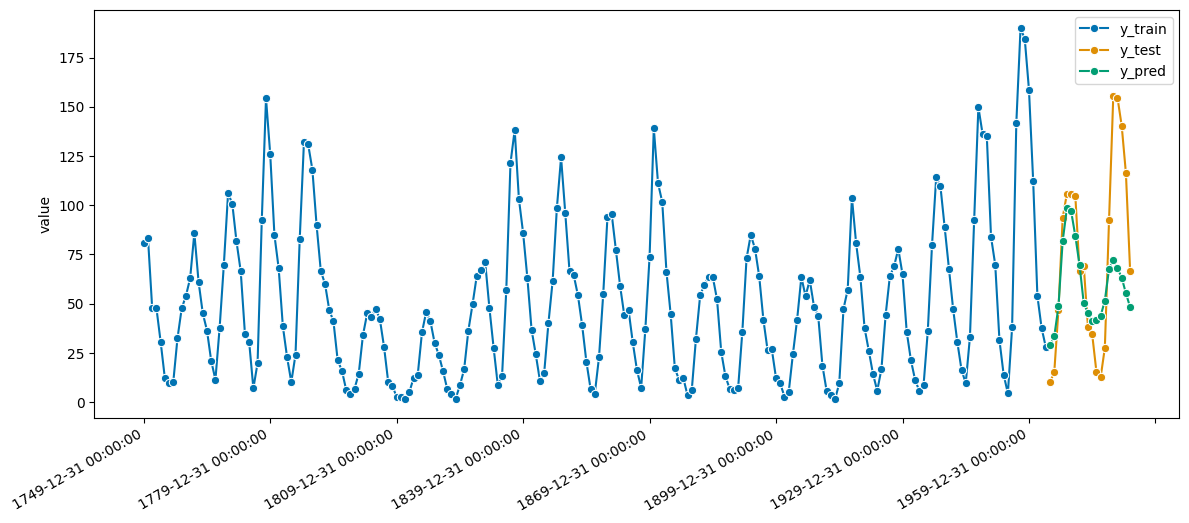

In [10]:
y_pred_arima = arima_forecaster.predict(fh=fh)

fig, _ = plot_series(y_train, y_test, y_pred_arima, labels=["y_train", "y_test", "y_pred"])
fig.set_size_inches(14, 6)
fig.autofmt_xdate()

plt.show()

In [11]:
# MAPE
mape_loss = MeanAbsolutePercentageError(symmetric=False)
smape_loss = MeanAbsolutePercentageError(symmetric=True)

In [12]:
print("AutoARIMA MAPE: ", mape_loss(y_test, y_pred_arima))
print("AutoARIMA sMAPE: ", smape_loss(y_test, y_pred_arima))

AutoARIMA MAPE:  0.6007073418560758
AutoARIMA sMAPE:  0.4602412712911491


#### ETS

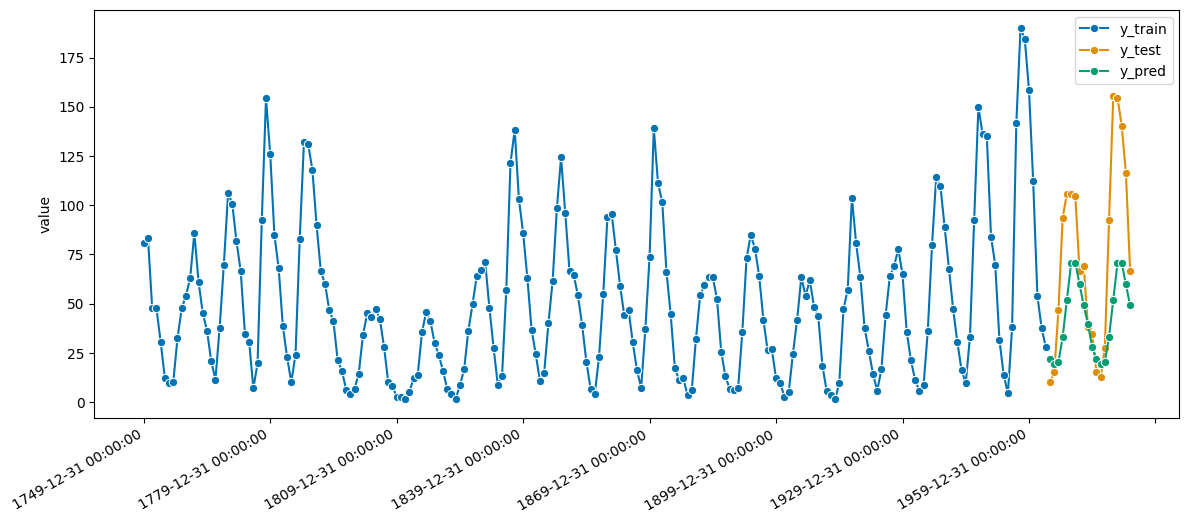

In [13]:
ets_forecaster = AutoETS(auto=True, sp=11, n_jobs=-1)
ets_forecaster.fit(y_train)
y_pred_ets = ets_forecaster.predict(fh=fh)

fig, _ = plot_series(y_train, y_test, y_pred_ets, labels=["y_train", "y_test", "y_pred"])
fig.set_size_inches(14, 6)
fig.autofmt_xdate()

plt.show()

In [14]:
print("AutoETS MAPE: ", mape_loss(y_test, y_pred_ets))
print("AutoETS sMAPE: ", smape_loss(y_test, y_pred_ets))

AutoETS MAPE:  0.4366920264728069
AutoETS sMAPE:  0.5116067723450369


#### Naive

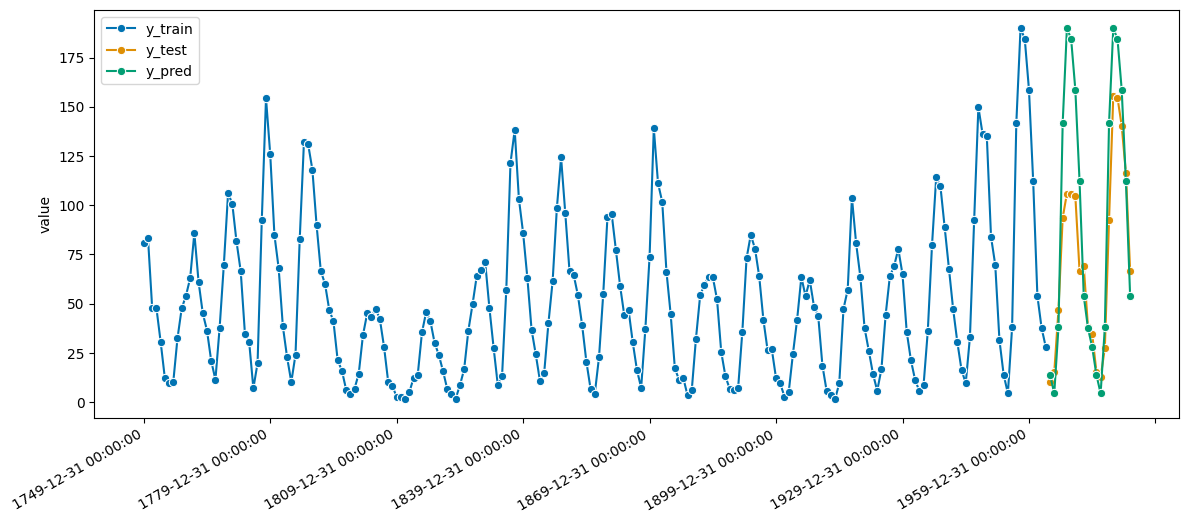

In [15]:
naive_forecaster = NaiveForecaster(strategy="last", sp=11)
naive_forecaster.fit(y_train)
y_pred_naive = naive_forecaster.predict(fh=fh)

fig, _ = plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred"])
fig.set_size_inches(14, 6)
fig.autofmt_xdate()

plt.show()

In [16]:
print("Naive MAPE: ", mape_loss(y_test, y_pred_naive))
print("Naive sMAPE: ", smape_loss(y_test, y_pred_naive))

Naive MAPE:  0.3684286848681362
Naive sMAPE:  0.35362110457783374


#### Ensemble

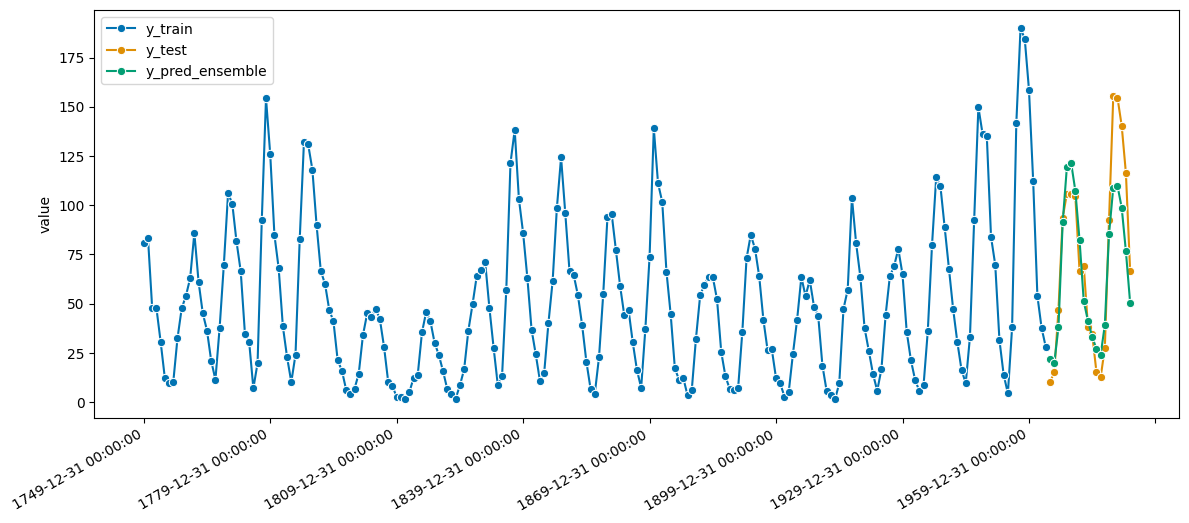

In [17]:
ensemble = AutoEnsembleForecaster(
    forecasters=[
        ("arima", AutoARIMA(seasonal=True, sp=11, suppress_warnings=True)),
        ("ets", AutoETS(auto=True, sp=11, n_jobs=-1)),
        ("naive", NaiveForecaster(strategy="last", sp=11)),
    ]
)
ensemble.fit(y_train)
y_pred_ensemble = ensemble.predict(fh=fh)

fig, _ = plot_series(
    y_train,
    y_test,
    y_pred_ensemble,
    labels=[
        "y_train",
        "y_test",
        "y_pred_ensemble",
    ],
)
fig.set_size_inches(14, 6)
fig.autofmt_xdate()

plt.show()

In [18]:
print("Ensemble MAPE: ", mape_loss(y_test, y_pred_ensemble))
print("Ensemble sMAPE: ", smape_loss(y_test, y_pred_ensemble))

Ensemble MAPE:  0.3103553238857475
Ensemble sMAPE:  0.27302567578986797
